In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix


## Data Exploration

In [2]:
df = pd.read_csv('data/netflix_titles.csv')

In [3]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [5]:
df.describe()

,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


In [6]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

## Handling Missing Values

In [10]:
# Fill missing values
df['country'] = df['country'].fillna('Unknown')
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])  # Fill with the mode for ratings
df['date_added'] = df['date_added'].fillna('Unknown')
df['duration'] = df['duration'].fillna('Unknown')

# Ensure 'duration' is treated as a string
df['duration'] = df['duration'].astype(str)

# Remove 'Unknown' from the duration column and convert durations to numeric
df = df[df['duration'] != 'Unknown']

# Convert 'duration' for movies and shows
movies_mask = df['duration'].str.contains('min', na=False)
shows_mask = df['duration'].str.contains('Season', na=False)

# Safely replace and convert the duration to numeric
df.loc[movies_mask, 'duration'] = df.loc[movies_mask, 'duration'].str.replace(' min', '').astype(float)
df.loc[shows_mask, 'duration'] = df.loc[shows_mask, 'duration'].str.replace(' Seasons', '').str.replace(' Season', '').astype(float)

# Convert the 'duration' column to numeric, setting errors='coerce' to handle any remaining non-numeric values
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')

## Data Preprocessing

In [16]:
# One-hot encode the categorical variables
df_encoded = pd.get_dummies(df, columns=['country', 'listed_in'], drop_first=True)

# Check if 'rating' exists in the DataFrame before encoding
if 'rating' in df.columns:
    # Create one-hot encoding for ratings
    rating_dummies = pd.get_dummies(df['rating'], prefix='rating', drop_first=True)
    df_encoded = pd.concat([df_encoded, rating_dummies], axis=1)

    # Define features and target variable
    X = df_encoded.drop(columns=['rating'])  # Drop 'rating' to create features
    y = rating_dummies  # Use the one-hot encoded rating columns

    print("Yes it worked")
else:
    raise KeyError("The 'rating' column is missing from the DataFrame.")

# Check for correct creation of y
print("Target variable shape (y):", y.shape)
print("Features shape (X):", X.shape)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure all features in X_train are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_val = X_val.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with 0
X_train.fillna(0, inplace=True)
X_val.fillna(0, inplace=True)

# Normalize the Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform the training data
X_val_scaled = scaler.transform(X_val)           # Only transform the validation data

# Convert DataFrames to PyTorch Tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)  # Ensure the data type is float
y_train_tensor = torch.FloatTensor(y_train.values)  # Target tensor
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values)

# Final shapes of the tensors
print("Training Feature Tensor shape:", X_train_tensor.shape)
print("Training Target Tensor shape:", y_train_tensor.shape)
print("Validation Feature Tensor shape:", X_val_tensor.shape)
print("Validation Target Tensor shape:", y_val_tensor.shape)

Yes it worked
Target variable shape (y): (8804, 13)
Features shape (X): (8804, 1283)
Training Feature Tensor shape: torch.Size([7043, 1283])
Training Target Tensor shape: torch.Size([7043, 13])
Validation Feature Tensor shape: torch.Size([1761, 1283])
Validation Target Tensor shape: torch.Size([1761, 13])


## Model Design

In [19]:
class NetflixRatingModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NetflixRatingModel, self).__init__()
        self.hidden1 = nn.Linear(input_size, 256)  # First hidden layer
        self.hidden2 = nn.Linear(256, 128)          # Second hidden layer
        self.relu = nn.ReLU()                        # ReLU activation
        self.output = nn.Linear(128, num_classes)   # Output layer with softmax activation

    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# Prepare the Data for Training
# Create Tensor datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
# Helps manage batches of data for training and evaluation
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Hyperparameters
input_size = X_train_tensor.shape[1]  # Number of features
num_classes = y_train_tensor.shape[1]  # Number of classes in the target variable


model = NetflixRatingModel(input_size, num_classes)

# Display the model architecture
print(model)

NetflixRatingModel(
  (hidden1): Linear(in_features=1283, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=128, out_features=13, bias=True)
)


## Training Function

In [20]:
num_epochs = 20  # Set the number of epochs
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer

# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        total_loss += loss.item()  # Accumulate loss

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')

Epoch [1/20], Loss: 0.7377
Epoch [2/20], Loss: 0.0949
Epoch [3/20], Loss: 0.0483
Epoch [4/20], Loss: 0.0262
Epoch [5/20], Loss: 0.0154
Epoch [6/20], Loss: 0.0143
Epoch [7/20], Loss: 0.0102
Epoch [8/20], Loss: 0.0087
Epoch [9/20], Loss: 0.0077
Epoch [10/20], Loss: 0.0061
Epoch [11/20], Loss: 0.0056
Epoch [12/20], Loss: 0.0048
Epoch [13/20], Loss: 0.0045
Epoch [14/20], Loss: 0.0044
Epoch [15/20], Loss: 0.0042
Epoch [16/20], Loss: 0.0042
Epoch [17/20], Loss: 0.0041
Epoch [18/20], Loss: 0.0041
Epoch [19/20], Loss: 0.0040
Epoch [20/20], Loss: 0.0040


## Evaluation

Validation Accuracy: 0.9659
Confusion Matrix:
         Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4  \
True 0             0            0            0            0            0   
True 1             0           14            0            1            0   
True 2             0            0           49            0            1   
True 3             0            0            2           99            3   
True 4             0            0            1            0          155   
True 5             0            0            0            0            5   
True 6             0            0            0            0            0   
True 7             0            0            0            0            0   
True 8             0            0            0            0            0   
True 9             0            0            0            0            0   
True 10            0            0            0            0            0   
True 11            0            0         

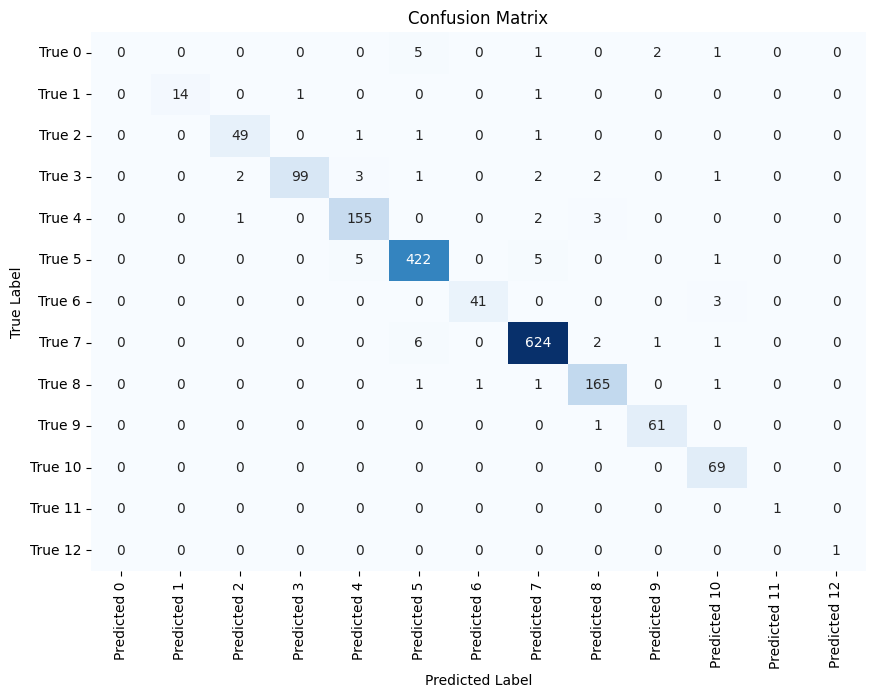

Predicted Rating Class: 7


In [28]:
model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in val_loader:
        outputs = model(inputs)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Get the predicted class

        # Append predictions and labels in their correct formats
        all_preds.extend(preds.numpy())
        
        # If your labels are one-hot encoded, convert them to class indices
        all_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert to class indices

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Validation Accuracy: {accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Convert the confusion matrix to a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, 
                               index=[f'True {i}' for i in range(conf_matrix.shape[0])],
                               columns=[f'Predicted {i}' for i in range(conf_matrix.shape[1])])

# Display the confusion matrix
print('Confusion Matrix:')
print(conf_matrix_df)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Rating Prediction (example)
example_input = X_val_tensor[0].unsqueeze(0)  # Example input
model.eval()
with torch.no_grad():
    prediction = model(example_input)
    predicted_rating = torch.argmax(prediction).item()
    print(f'Predicted Rating Class: {predicted_rating}')